# Confocal Data Analysis Example

**Authors:** *Alan Baldwin* wrote all code using the phconvert package (the vast majority). *Kieran Orr* added code using the HyperSpy package and wrote most of the information in the markdown cells and has added comments in the raw cells. *May 2021.*

**The data** was collected on MAPbBr<sub>3</sub> microcrystals by *Kieran Orr* in Cambridge, in *November 2021*. Some elements of the analysis may not apply to thin film samples (removing background for example).

## 1. Loading required packages 

Load required modules. **Note** that the `Picoquant_PL.py` file is the python package that we import here. It needs to be in the same direcotry as the notebook.

**Note**, in addition to [matplotlib](https://matplotlib.org/stable/index.html) (whcih you most likely already have installed), you will need to install [phconvert](http://photon-hdf5.github.io/phconvert/).

To do this, in you Anaconda environment in Anaconda Prompt run `conda install -c conda-forge phconvert`.

In [2]:
import Picoquant_PL as pl
import matplotlib.pyplot as plt
import numpy as np

## 2. Loading files 

Import the ptu file and metadata and convert it into a data cube. 

**Note** that the reason we specify two objects, one called `data`, and the other called `tags`, is because the `pl.import_convert()` funtion returns two objects. It returns an array of the data and an ordered dictionary containin the metadata about the file.

If simply said `info = pl.import_convert([...])` then `info[0]` would be the data cube (array) and `info[1]` would be the metadata (ordered dictionary).

In [4]:
data, tags = pl.import_convert('MAPbBr3_nodunkblow_crystal7_2P_0p5um_100xSWD_8MHz_1400au_800nm_50frames', detector=1)

 - Loading 'MAPbBr3_nodunkblow_crystal7_2P_0p5um_100xSWD_8MHz_1400au_800nm_50frames.ptu' ... 
 [DONE]



## 3. Plotting the data

### 3.1. Overall TSSPC decay

Plot the overall TCSPC decay with the follwing cell. **Note** that this is the sum PL from every pixel. If we divided this by the number of pixels in the map it would be the average TCSPC decay.

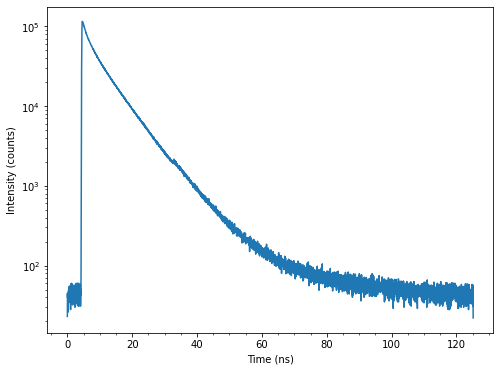

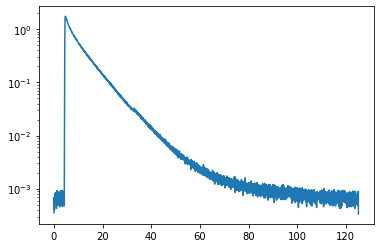

In [5]:
t, counts = pl.tcspc(data, tags)
counts= counts/(len(data[0])*len(data[1]))
fig, ax = plt.subplots()
ax.plot(t, counts)
ax.set_yscale('log')

### 3.2. PL intensity map

This fucntion plots the PL imtensity map. 

**Note** that similar to above, we have given specified three objects on the left hand side of the definition below. `PL_array` is the data cube containg the PL intensity values for each pixel. `scale_bar_len_um` is the size of the scale bar in um, and `scale_bar_len_um` is the size of the scale bar in pixels.

If we onyl gave one object on the left, such as `PL_int = pl.plot_pl(data, tags)` then the intensity array would be `PL_int[0]`, the scale bar length in um `PL_int[1]`, and the scale bar length in pixels `PL_int[2]`.

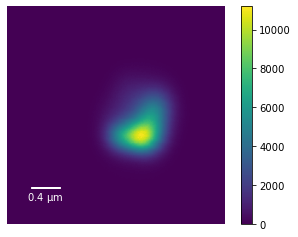

In [12]:
pl_array, scale_bar_len_um, scale_bar_len_pixels = pl.plot_pl(data, tags)

Sometimes it is easier to see the PL image if a log scale is used. This requires all pixels to have at least one count. This can be done as follows.

It is easier to create a copy of the data array and make any changes to this

In [13]:
data1 = data.copy()
data1[..., 0][pl_array == 0] = 1

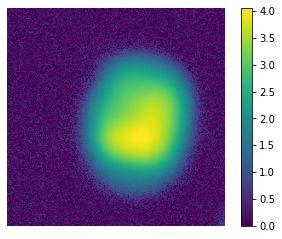

In [14]:
fig, ax = plt.subplots()

img = ax.imshow(np.log10(data1.sum(2)))

fig.colorbar(img)
ax.axis('off')

plt.show()

### 3.3. Fast flim 

This function plots the Fast Flim (Mean Arrival Time), $t_m$, which is given by

$$t_m = \frac{\sum_{i = 0}^N t_i \times c_i}{\sum_{i = 0}^N c_i}$$

where t$_i$ is the TCSPC bin and c$_i$ are the number of photon counts at that time.

C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 1\Microscope\confocal_analysis_Jupyter\Files from Alan\Picoquant_PL.py:477: RuntimeWarning: invalid value encountered in true_divide
  fast_flim = (t[None, None, :]*data[..., argmax:]).sum(2)/(data[..., argmax:].sum(2))


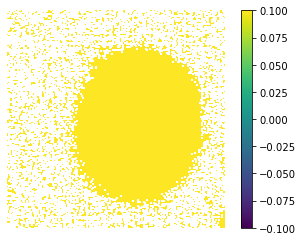

In [15]:
fflim = pl.plot_fast_flim(data, tags)

There are clearly issues with this plot. We can clean it up with masking.

To remove the noise that is not from the PL of the crystal we can set the fast flim time of each pixel which has less than half the mean number of PL intensity counts to be zero. This is acheved in the next cell. **Note** that doing it this way is faster than using a "for-loop" that iterates through each element of the array.

In [16]:
fflim[pl_array < pl_array.mean()/2] = 0

Now, we can plot cleaner version of fast flim.

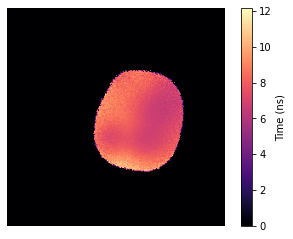

In [17]:
fig, ax = plt.subplots()

img = ax.imshow(fflim, cmap='magma')

fig.colorbar(img, label='Time (ns)')
ax.axis('off')

plt.show()

### 3.4. 1/e decay time 

This fucntiuon plots the time taken for the each pixel's PL decay to reach $\frac{1}{e}\times I_0$, where $I_0$ is the initial intensity. 

In [18]:
_1e_times = pl.plot_1e_time(data, tags)

ValueError: operands could not be broadcast together with shapes (54540,) (65536,) 

This cell can sometimes return an error. To figure out why, let's first check the size of the `data` array:

In [19]:
data.shape

(256, 256, 5006)

All seems fine. So there are probably pixels which recorded zero counts, the 1e calculation cannot handle these.

To make the function work, the pixels with no counts need to record one photon at evey TCSPC bin. In the next cell, we set every instance of zero counts to one count.

In [20]:
data1[pl_array < 1] = 1    
#note that PL_array is returned by pl.plot_pl() above. That cell must, therefore, be run before this one.

Let's try and plot the 1/e times again:

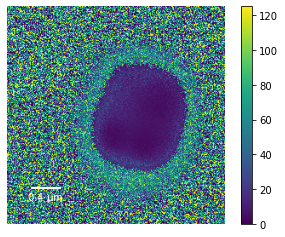

In [21]:
_1e_times = pl.plot_1e_time(data1, tags)

There is still lots of noise in the background, so let's here use the same trick as we did above and set all pixels with less than half the mean value of counts to 1.

In [22]:
data1[pl_array < pl_array.mean()/2] = 1

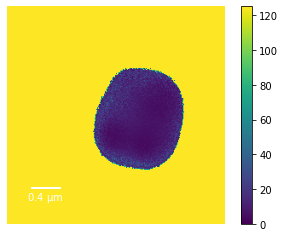

In [23]:
_1e_times = pl.plot_1e_time(data1, tags)

#### 3.4.1. Rebinning: Assessing the data (can skip this section if desired)

We can bin array in space and time to improve the quality of the result. The noise is reduced by a factor equal to the square root of the number of old bins combined into the new bin. For example, spatially bining by 2 in each sptial direction makes each new pixel the sum of four old pixels, and so the noise is reduced by a factor of $\sqrt{4}=2$. 

As a rule of thumb, one needs about 1000 counts initially in a TCSPC decay in order to extract reliable lifetime information.

Plot the data. Two new interactive windows will appear when you run this cell. One is a map of the PL of the sample. The other is the TCSPC decay for the red pixel.

You can move the red pixel around by clicking with the mouse. To enable interactivity qt or notebook (jupyter notebook)/widget (jupyter lab) is required.

In [24]:
%matplotlib notebook

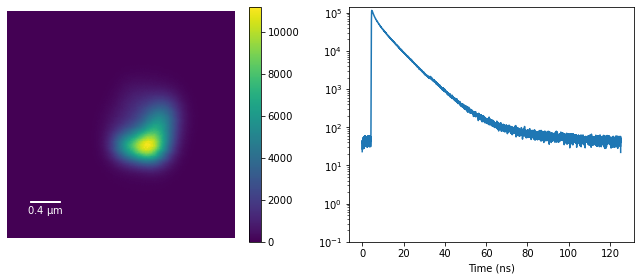

In [8]:
pl.plot_interactive_pl(data, tags)

We can use this interactivity to quickly get an understanding of our data. We can also see how many counts we have at the start of the TCSPC decays which will inform how we bin our data.

For this dataset, it seems that binning by 2 to 1 in each spacial dimention and by 10 to 1 in the time domain will be sufficient.

Back to inline not interactive inline plots.

In [27]:
%matplotlib inline

Now we plot the 1/e times with a binning of 10 to 1 in time domain and 2 to 1 in space:

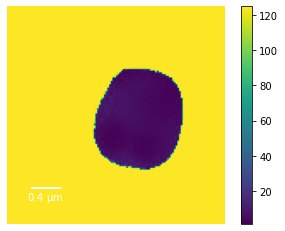

In [28]:
_1e_times = pl.plot_1e_time(data1, tags, time_binning = 10, shape_binning = 2)

Now, the background has very long 1/e times which is an artefect from the data processing so far. We want to set the backgroud 1/e values to zero. This is achieved in the next cell.

In [29]:
_1e_times[_1e_times == _1e_times.max()] = 0

Plot cleaner version of 1e times. Here we have also iterated the `vmax` value (the maximum of the colour bar) and found 12ns to be about optimal.

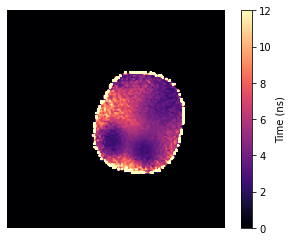

In [30]:
fig, ax = plt.subplots()

img = ax.imshow(_1e_times, cmap='magma', vmin=0, vmax=12)

fig.colorbar(img, label='Time (ns)')
ax.axis('off')

plt.show()

Clean up the edges of the cyrstal by setting the remaining long 1/e lifetimes (here, over 14ns) to zero as well.

In [31]:
_1e_times[_1e_times > 14] = 0

Now plot the figure again.

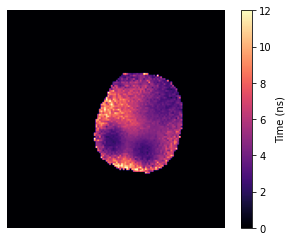

In [32]:
fig, ax = plt.subplots()

img = ax.imshow(_1e_times, cmap='magma', vmin=0, vmax=12)

fig.colorbar(img, label='Time (ns)')
ax.axis('off')

plt.show()

#### Finishing up the figure 

Now we are happy with the appearance of the crystal in the figure we can crop the plot to show the crystal as clearly as possible.

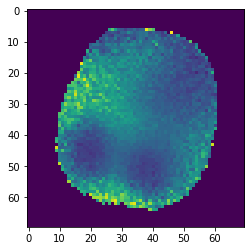

In [33]:
cropped = _1e_times[31:101, 42:112]    
#iterate the start and stop pixel numbers for the y direction and x direction here to get the correct size of array

plt.imshow(cropped)

**Note** that we could have doen the cropping earlier and cropped the `data` array. If we were doing that we would have to remember that the data array contained the TCSPC decays as well and so is a 3-dimensional array. As such we would have to crop with `croppped = data[start_y:end_y, start_x:end_x, :]`, where the blanks either side of the final dimension indicate that we want to keep the whole of the TCSPC axis.

Plot the completed figure:

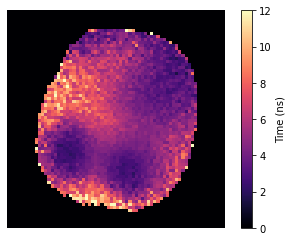

In [34]:
fig, ax = plt.subplots()

img = ax.imshow(cropped, 
                cmap='magma',
                vmin=0, 
                vmax=12)

fig.colorbar(img, label='Time (ns)')
ax.axis('off')

plt.show()